# Figure 7 - Individual patients time series

Plot a selection of time series for a subset of patients (the ones with the most measurements)

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [2]:
# Loading filtered dataset
filename = 'data/MFI_with_RS_new_filtering.csv'
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [3]:
# We need to standardize the way in which we compile the time series of each patient:
# For missing Abs, we should add a 499,499,... or a NaN,NaN,... time series
ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
ALL_ABS = df_filtered['I_NAM'].unique()

def get_time_series(df, Ab_id, dummy_value_inter=499, dummy_value_whole=np.nan):    
    # Transform into datetime objects for sorting
    dates = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in list(df['IL_DAT'].unique())]
    dates = sorted(dates)
    
    # Check if there is any value matching the ab id
    values = []
    if Ab_id in df['I_NAM'].values:
        for date in dates:
            str_date = datetime.datetime.strftime(date, '%d.%m.%Y')
            df_date = df[df['IL_DAT']==str_date]
            if Ab_id in df_date['I_NAM'].values:
                val = df_date[df_date['I_NAM'] == Ab_id]['I_VAL'].values
                values.append(float(val[0]))
            else:
                values.append(dummy_value_inter)
        return np.asarray(values), dates
    else:
        return dummy_value_whole*np.ones(len(dates)), dates

def get_evolution_df(df, complete=False, analysis_type='1'):
    evo_df = pd.DataFrame()
    if complete:
        # Need to check if we only consider type1 or type2 or both...
        if analysis_type == '1':
            # CAREFUL: There is no automatic check to verify...
            list_abs = ALL_ABS_TYP1 # Generate a ts for every ab
        elif analysis_type == '2':
            list_abs = ALL_ABS_TYP2
        else:
            list_abs = ALL_ABS
    else:
        list_abs = list(df['I_NAM'].unique()) 
    for ab_id in list_abs:
        ts, dates = get_time_series(df[df['TYP']=='Lumi-Single-Klasse'+analysis_type], ab_id, dummy_value_inter=499, dummy_value_whole=499)
        evo_df[ab_id] = ts
    dates = pd.DatetimeIndex(dates)
    evo_df = evo_df.set_index(dates)
    return evo_df

In [4]:
# Unfortunately patients have non-matching time series for the 2 classes of assays
# hence we will have two sets of time-series for each patients.
def filter_patients(df_in, analysis_type="1"):
    df_filtered_typ = df_in[df_in['TYP']=='Lumi-Single-Klasse'+ analysis_type]
    # Let's only keep patients with at least 2 measurements
    df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
    print('{} patients need to be excluded as they only have one date of measurements.'.format((df_n==1).sum()))
    df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]
    return df_filtered_typ

df_filtered_typ1 = filter_patients(df_filtered)
df_filtered_typ1['RSNR'].nunique()

17 patients need to be excluded as they only have one date of measurements.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


438

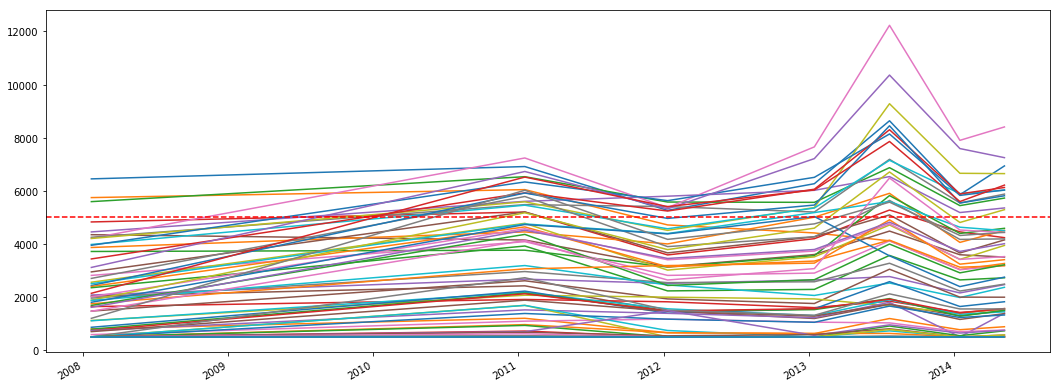

In [6]:
# Plot timeseries for patient of interest
ax = patient_ts.plot(legend=False, figsize=(18,7))
ax.axhline(5000, color='r', linestyle='--')

In [7]:
# Select patients with the most observations
topten = df_filtered_typ1.groupby('RSNR')['IL_DAT'].nunique().sort_values()[::-1][:10]
# print(topten)
topten = list(topten.index)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


In [8]:
# Collect their multidim timeseries
topten_tes = []
for rs in topten:
    a = get_evolution_df(df_filtered_typ1.loc[rs], complete=True, analysis_type='1').drop(np.nan, axis=1)
    topten_tes.append(a.reindex(sorted(a.columns), axis=1))

In [9]:
# Get total span of time of patients
dates = []
for tt in topten_tes:
    dates.append(tt.index)
dates = pd.DatetimeIndex(np.concatenate(dates))

In [10]:
dates.max()

Timestamp('2017-08-08 00:00:00')

In [11]:
# Invert order to avoid covering the legend
a = topten_tes[4]
topten_tes[4] = topten_tes[-1]
topten_tes[-1] = a

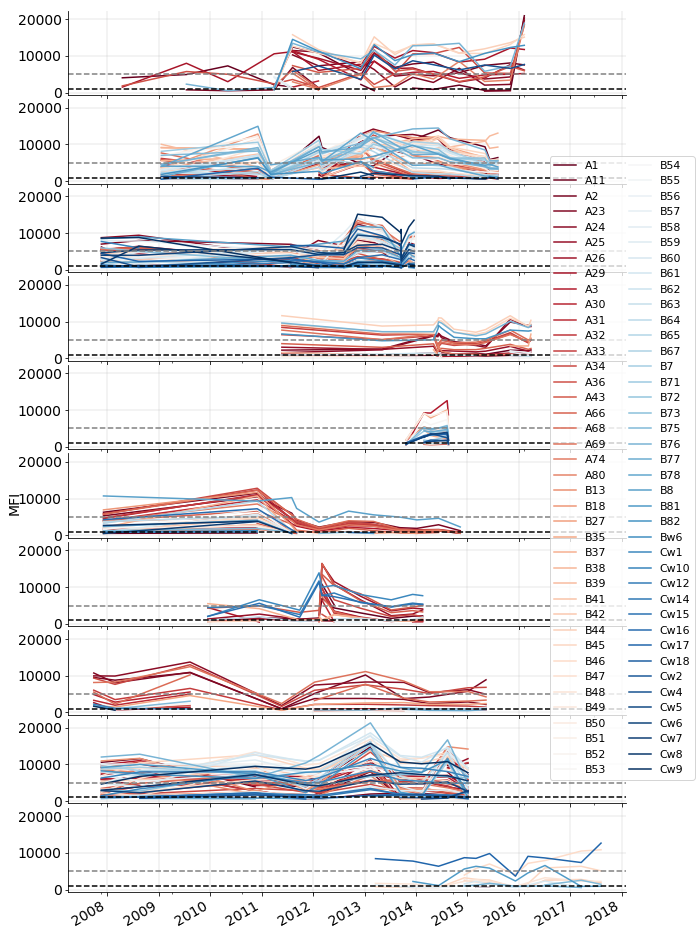

In [12]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(10,1,sharex=True, sharey=True, figsize=(10, 18), gridspec_kw={'hspace':0.05})
for i,x in enumerate(ax):
#     x.set_yscale("log")
    topten_tes[i].replace(499, np.nan).plot(legend=False, ax=x, colormap='RdBu')
    x.axhline(5000, color='grey', lw=1.5, linestyle='--')
    x.axhline(1000, color='black', lw=1.5, linestyle='--')
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.grid(linewidth=0.3)
fig.legend(loc='center right', ncol=2, fontsize=11)
fig.text(0.04, 0.5, 'MFI', va='center', rotation='vertical')
plt.rcParams.update({'font.size': 11})
# plt.tight_layout()
# plt.savefig("paper/figures/plots/patient_timelines_topten.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("paper/figures/plots/patient_timelines_topten.png", bbox_inches='tight')

In [13]:
# We only plot 1,6,7,8 extensively (with class 1 and class 2)
topfour = [topten[i] for i in [0,5,6,7]]
topfour_tes = []

df_filtered_typ2 = filter_patients(df_filtered, analysis_type='2')
for rs in topfour:
    a1 = get_evolution_df(df_filtered_typ1.loc[rs], complete=True, analysis_type='1').drop(np.nan, axis=1)
    a1 = a1.reindex(sorted(a1.columns), axis=1)
    a2 = get_evolution_df(df_filtered_typ2.loc[rs], complete=True, analysis_type='2').drop(np.nan, axis=1)
    a2 = a2.reindex(sorted(a2.columns), axis=1)
    topfour_tes.append([a1,a2])
            

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


20 patients need to be excluded as they only have one date of measurements.


In [24]:
# Ideal cubehelix palette
cubehelix_pal_old = sns.cubehelix_palette(6, start=.3, rot=-.8, gamma=0.6, hue=0.95, light=0.8, dark=0.1,
                                         reverse=True)

In [25]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(cubehelix_pal_old)

In [16]:
# Need to extract the colors for individual antigens
topfour_tes[0][0].columns
# Find out about the location of the loci in the dataset:
counters = dict()
loci = ['A', 'B','Cw', 'DR', 'DQ', 'DP'] # There is one Bw but we will pool it in B
for l in loci:
    counters[l]=0
    
# initiate the list of list of columns
from collections import defaultdict
cset = defaultdict(list)
for i in [0,1]:
    for a in topfour_tes[0][i].columns:
        prefix = ''.join([i for i in a if not i.isdigit()])
        if prefix == 'Bw':
            prefix = 'B'
        counters[prefix]+=1
        cset[prefix].append(a)
for l in loci:
    print("{} in locus {}.".format(counters[l], l))
# colors.colors

21 in locus A.
44 in locus B.
15 in locus Cw.
18 in locus DR.
7 in locus DQ.
18 in locus DP.


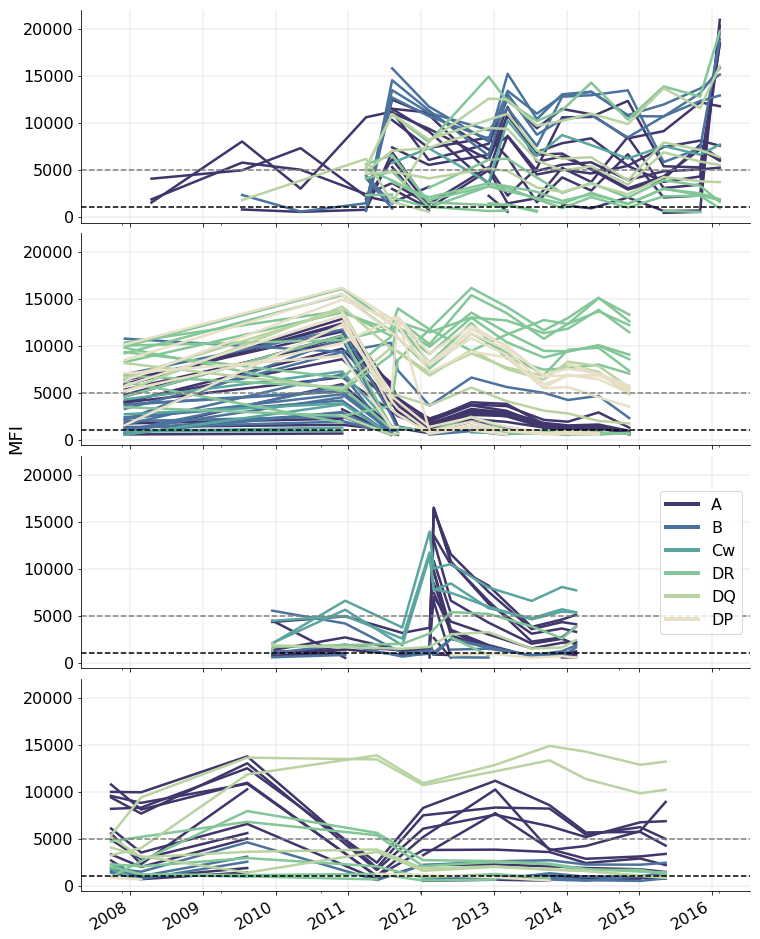

In [27]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(4,1,sharex=True, sharey=True, figsize=(12, 18), gridspec_kw={'hspace':0.05})
for i,x in enumerate(ax):
#     x.set_yscale("log")
    for j, loci in enumerate(['A', 'B', 'Cw']):
        topfour_tes[i][0][cset[loci]].replace(499, np.nan).plot(legend=False, ax=x, 
                                                                c=colors.colors[j], label=loci,
                                                               linewidth=2.5)
    
    for j, loci in enumerate(['DR', 'DQ', 'DP']):
        topfour_tes[i][1][cset[loci]].replace(499, np.nan).plot(legend=False, ax=x, 
                                                                c=colors.colors[3+j], label=loci,
                                                               linewidth=2.5)
    x.axhline(5000, color='grey', lw=1.5, linestyle='--')
    x.axhline(1000, color='black', lw=1.5, linestyle='--')
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.grid(linewidth=0.3)
# fig.legend(loc='center right', ncol=2, fontsize=11)
fig.text(0.04, 0.55, 'MFI', va='center', rotation='vertical', fontsize=18)

# Custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors.colors[i], lw=4) for i in range(6)]

ax[2].legend(custom_lines, ['A', 'B', 'Cw', 'DR', 'DQ', 'DP'], loc='center right')
plt.rcParams.update({'font.size': 11})

fig.savefig('paper/figures/plots/patients_trajectories_cubehelix.png')
fig.savefig('paper/figures/plots/patients_trajectories_cubehelix.pdf')